### О кейсе

Кейс состоит из последовательных вопросов

(отвечать на них обязательно, код и графики без интерпретации не имеют никакого смысла, **иначе - снижение баллов**), посвященных работе с табличными данными, но на более низком уровне с помощью Numpy

Баллы даются за выполнение отдельных пунктов

(Максимальное количество баллов за этот кейс - 10 (чтобы вам было проще оценивать свои успехи))

Задачи в рамках одного раздела рекомендуется решать в том порядке, в котором они даны в задании.

В этом задании мы попытаемся научиться анализировать данные и выделять из них полезные признаки. Мы также научимся пользоваться `seaborn` и `sklearn`, а заодно привыкнем к основным понятиям машинного обучения.

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо считываемые диаграммы.

Если эксперт заметит плагиат - баллы за ваше решения также снижаются.


# Кейс

## Часть 0. Подготовка [+0.5 балла]

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_log_error

**Задание 1 [+0.5 балла]**. Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси. Скачайте обучающую выборку из этого соревнования и загрузите ее:

In [2]:
!gdown --id 1hhYPTjPrIP-fONMLF6iNEx4VgFQr-rSe -O train.csv


/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1hhYPTjPrIP-fONMLF6iNEx4VgFQr-rSe
From (redirected): https://drive.google.com/uc?id=1hhYPTjPrIP-fONMLF6iNEx4VgFQr-rSe&confirm=t&uuid=c7d65a6a-2218-4390-89ba-821e74168f69
To: /content/train.csv
100% 201M/201M [00:04<00:00, 48.2MB/s]


In [3]:
!gdown --id 1hhYPTjPrIP-fONMLF6iNEx4VgFQr-rSe -O test.csv


/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1hhYPTjPrIP-fONMLF6iNEx4VgFQr-rSe
From (redirected): https://drive.google.com/uc?id=1hhYPTjPrIP-fONMLF6iNEx4VgFQr-rSe&confirm=t&uuid=4baa8168-517d-4857-8dbf-f0f95bc501e5
To: /content/test.csv
100% 201M/201M [00:00<00:00, 230MB/s]


In [3]:
df_train = pd.read_csv('train.csv')
df_train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [4]:
df_train.shape

(1458644, 11)

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


В колонке `dropoff_datetime` содержится информация о времени окончания поездки, однако эта колонка присутствует только в обучающей выборке и отсутствует в тестовой. Это создаёт проблему, так как при обучении модели мы не сможем использовать эту колонку для предсказаний на новых данных. В связи с этим, чтобы избежать ошибок и упростить анализ, рекомендуется удалить колонку `dropoff_datetime` из датасета.

Колонка `pickup_datetime` содержит дату и время начала поездки в формате строки, что затрудняет выполнение операций с датами и временем, таких как вычисление продолжительности поездки или анализ зависимости цены от времени суток. Преобразование этих данных в `datetime`-объекты позволит использовать методы для работы с датой (вместо огромного количества строк для решения какой-нибудь маленькой подзадачи будет использоваться один вызов метода)

In [6]:
df_train.drop('dropoff_datetime', axis=1, inplace=True)

In [7]:
df_train['pickup_datetime'] = pd.to_datetime(df_train.pickup_datetime)

В колонке `trip_duration` содержится значение, которое мы стремимся предсказать. Давайте изучим распределение целевой переменной в обучающем наборе данных. Для этого построим гистограмму этой переменной.

Построение гистограммы целевой переменной важно по нескольким причинам:

1. **Понимание распределения**: Гистограмма помогает нам увидеть, как распределены значения целевой переменной. Это может дать представление о том, является ли распределение нормальным, скошенным или имеет выбросы.

2. **Выявление аномалий**: При анализе гистограммы мы можем обнаружить аномальные значения или выбросы, которые могут повлиять на качество модели.

3. **Выбор подходящего алгоритма**: Понимание распределения целевой переменной может помочь в выборе наиболее правильного анализа датасета. Например, если данные сильно скошены, может потребоваться преобразование данных перед обучением модели. (как на практическом занятии, если у нас таргет расположен по экспоненте, то было бы классно предсказывать логарифм, а не экспоненту (подробнее было на лекции))


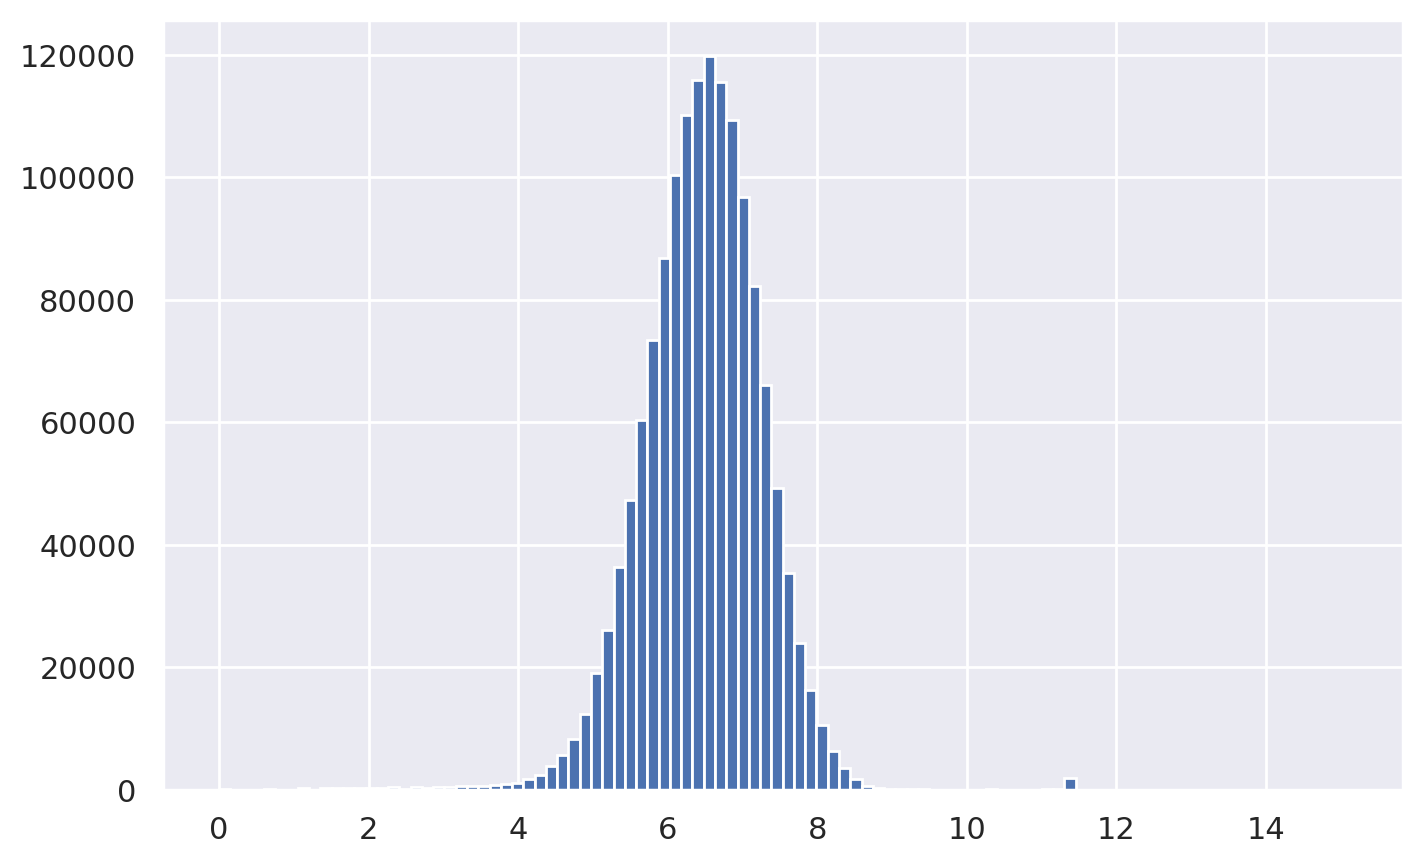

In [14]:
df_train['trip_duration'].apply(np.log).hist(bins=100);

**Вопрос**: Что можно сказать о целевой переменной по гистограмме её значений?

- распределение нормальное
- есть выбросы

В соревновании в качестве метрики качества использовалось RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Вопрос**: Как вы думаете, почему авторы соревнования выбрали именно RMSLE, а не RMSE?

Мы изучили несколько вариантов линейной регрессии в sklearn, но все они минимизировали среднеквадратичную ошибку (MSE), а не среднеквадратичную логарифмическую ошибку (RMSLE). Для работы с RMSLE мы можем использовать следующий подход: вместо прямого предсказания целевой переменной, мы будем предсказывать ее логарифм. Пусть $\hat{y}_i = \log{(y_i + 1)}$ будет модифицированной целевой переменной, а $\hat{a}(x_i)$ — предсказание модели, обученной на $\hat{y}_i$. Чтобы получить исходное предсказание, мы используем обратное преобразование: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

\

Это преобразование позволяет нам оптимизировать MSE для логарифмированных значений, что эквивалентно оптимизации RMSLE для исходных значений. Это связано с тем, что минимизация квадратичной ошибки между логарифмами прогнозов и реальных значений соответствует минимизации логарифмической ошибки между самими прогнозами и реальными значениями ***(для дополнительного балла можете доказать почему)***. Таким образом, этот подход позволяет использовать стандартные методы линейной регрессии для задач, где требуется минимизировать RMSLE.






In [ ]:
#╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

Чтобы иметь некоторую точку отсчета, давайте посчитаем значение метрики при наилучшем константном предсказании:

***(Какая константа прекрасно оптимизирует RMSLE MSE (с преобразованиями?))***

чето с производной, в хендбуке

In [15]:
def rmsle(log1p_y_true, log1p_y_pred):
    return np.sqrt(np.mean((np.log1p(log1p_y_true) - np.log1p(log1p_y_pred))**2))

rmsle_best_const = df_train.trip_duration.apply(np.log1p).mean()
print(rmsle_best_const)
#assert np.allclose(rmsle_best_const, 0.79575, 1e-4) # ответ конечно же нельзя подсматривать

6.466978409297406


## Часть 1. Изучаем `pickup_datetime` & Обучаем модель [+1 балл]


**Задание 2 [+0.125 балла]**. Для начала давайте проанализируем общее количество поездок по дням. Построим график, отражающий зависимость числа поездок от конкретного дня в году (например, можно использовать `sns.countplot`).

Просмотр этой информации важен по нескольким причинам:

1. **Выявление закономерностей**: Анализ количества поездок по дням может помочь выявить определенные закономерности или тренды, например, повышенный спрос в выходные дни или праздничные периоды.

2. **Обнаружение аномалий**: График может помочь идентифицировать дни с необычно высоким или низким количеством поездок, что может указывать на наличие аномалий или особых событий.

3. **Корректировка моделей**: Если анализ показывает, что спрос сильно колеблется в зависимости от дня, это может потребовать учета этого фактора в моделях прогнозирования.

In [10]:
df_train.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration'],
      dtype='object')

<Axes: xlabel='day_of_year', ylabel='count'>

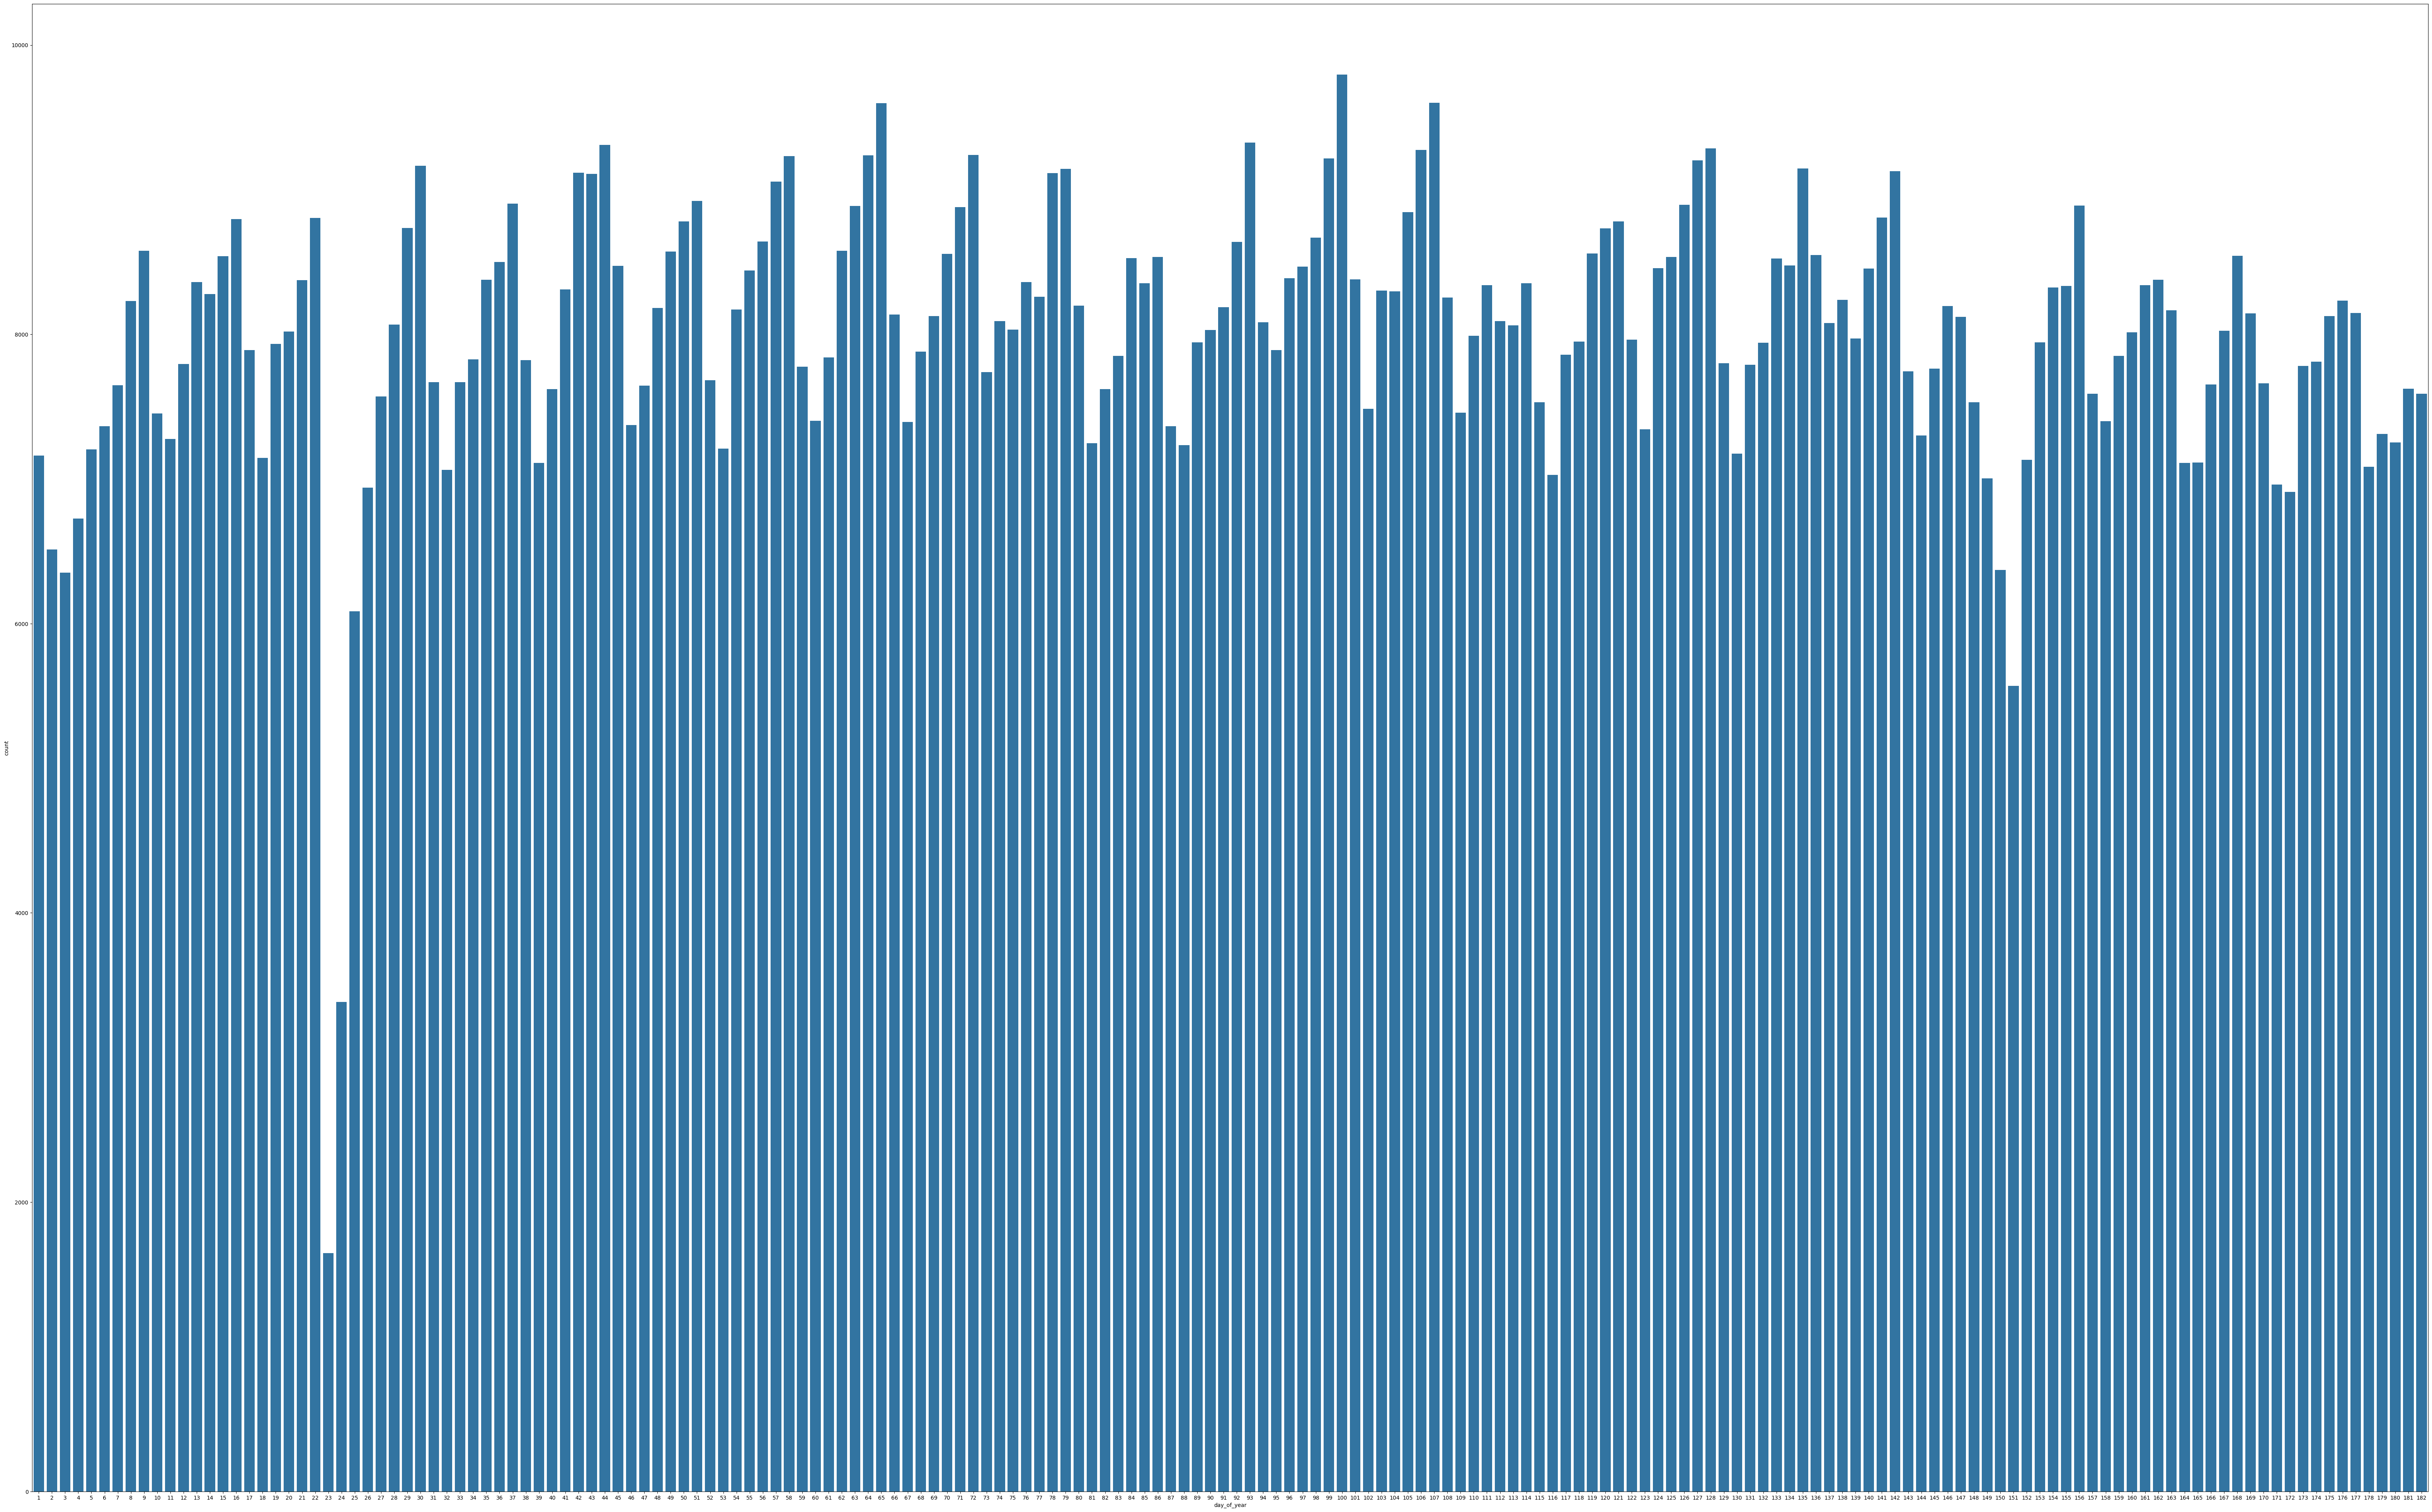

In [8]:
df_train['day_of_year'] = df_train['pickup_datetime'].dt.dayofyear

plt.figure(figsize=(80, 50))
sns.countplot(x='day_of_year', data=df_train)

In [12]:
days = df_train[df_train['day_of_year'] == 23]
day = days.iloc[0].pickup_datetime
print(day)

2016-01-23 08:46:42


In [ ]:
days = df_train[df_train['day_of_year'] == 151]
day = days.iloc[0].pickup_datetime
print(day)

2016-05-30 13:33:07


**Вопрос**: Вы, вероятно, заметили, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.

Нарисуйте графики зависимости количества поездок от дня недели и от часов в сутках (воспользуйтесь `sns.relplot`):

https://en.wikipedia.org/wiki/January_2016_United_States_blizzard c 22 по 24 была буря
https://tass.ru/proisshestviya/3324970 массовая стрельба


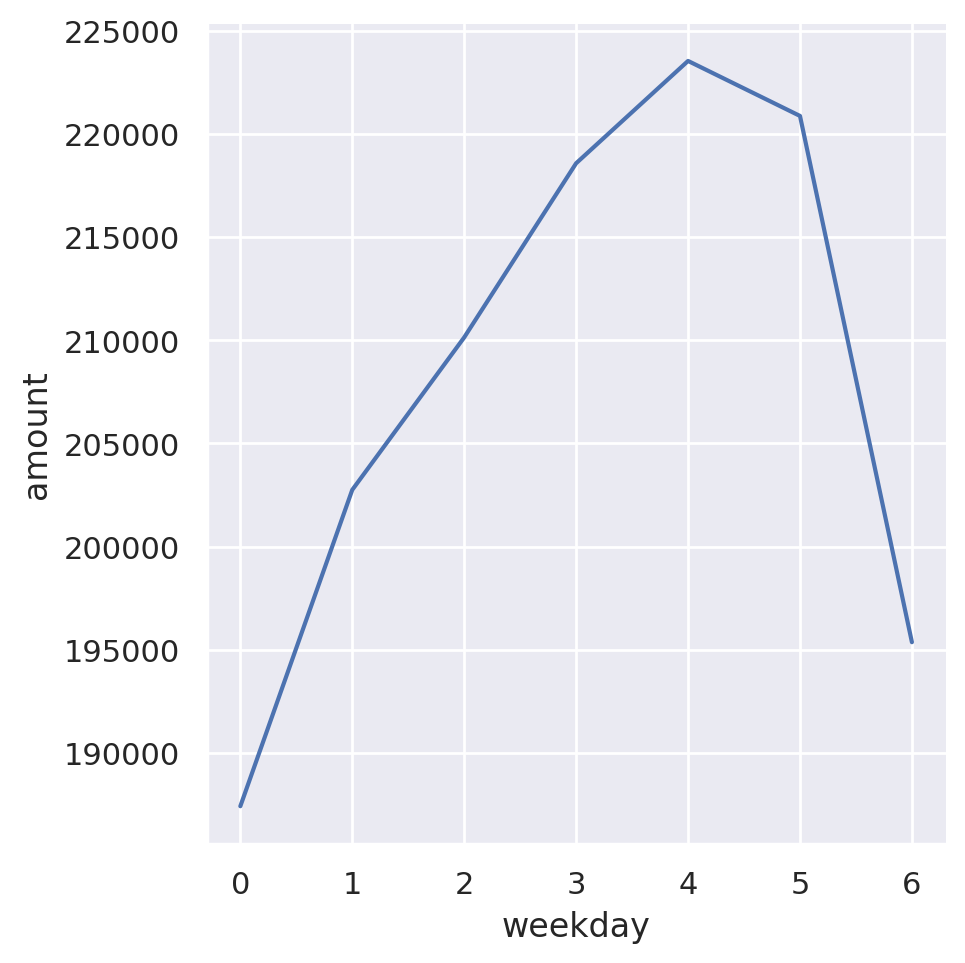

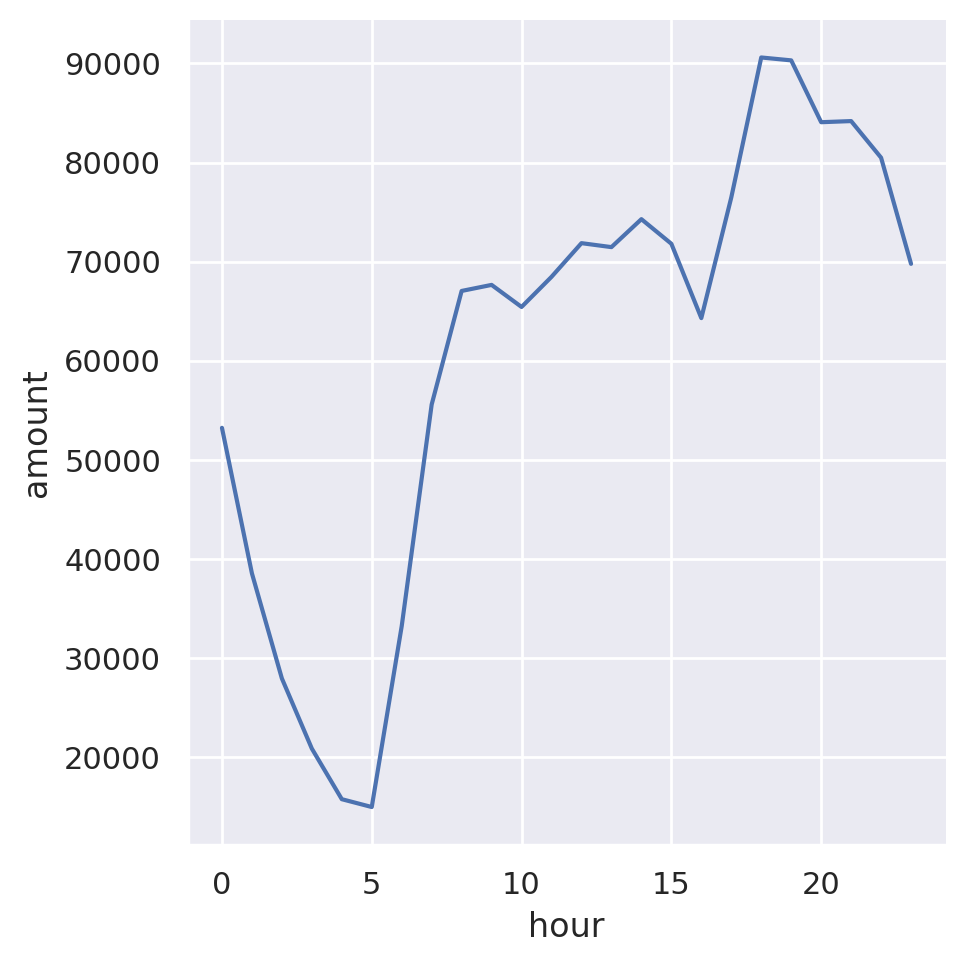

In [16]:
# Создадим столбец с днем недели
df_train['weekday'] = df_train['pickup_datetime'].dt.dayofweek

# Создадим столбец с часом начала поездки
df_train['hour'] = df_train['pickup_datetime'].dt.hour

# Группируем по дню недели и по часам и считаем количество поездок
count_by_weekday = df_train.groupby('weekday').count()['id'].reset_index(name='amount')
count_by_hour = df_train.groupby('hour').count()['id'].reset_index(name='amount')

# Нарисуем график зависимости количества поездок от дня недели
sns.relplot(x='weekday', y='amount', kind='line', data=count_by_weekday)

# Нарисуем график зависимости количества поездок от часа в сутках
sns.relplot(x='hour', y='amount', kind='line', data=count_by_hour)

**Задание 3 [+0.25 балла]**. Постройте график, на котором будет отображена зависимость числа поездок от времени суток для различных месяцев. Используйте разные цвета для кривых, соответствующих разным месяцам, с помощью параметра `hue` в `sns.relplot`. Аналогичным образом постройте график, показывающий зависимость количества поездок от часа в сутках для разных дней недели.

Это важно по нескольким причинам:

1. **Выявление временных закономерностей**: Графики помогут увидеть, как спрос на поездки меняется в течение суток в разные месяцы и дни недели. Это может выявить определенные тренды, например, пиковые часы поездок или временные периоды с низким спросом.

2. **Адаптация к сезонности и недельным циклам**: Понимание того, как спрос на поездки меняется в зависимости от времени года и дня недели, позволяет адаптировать модель машинного обучения и сделать правильный feature-engineering (правильную предобработку данных)




In [17]:
df_train['month'] = df_train['pickup_datetime'].dt.month

In [18]:
in_month = df_train.groupby(['month', 'hour']).size()
in_month = in_month.reset_index(name='amount')

In [19]:
in_weekday = df_train.groupby(['weekday', 'hour']).size()
in_weekday = in_weekday.reset_index(name='amount')

In [21]:
month_names = {
    1: 'Январь',
    2: 'Февраль',
    3: 'Март',
    4: 'Апрель',
    5: 'Май',
    6: 'Июнь'
}

in_month['month'] = in_month['month'].map(month_names)

In [20]:
%config InlineBackend.figure_format = 'retina'

# sns.set(style='whitegrid', palette='deep')
# sns.set(style='darkgrid', palette='rocket')
sns.set(style='darkgrid', palette='deep')

plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['font.size'] = 12
plt.rcParams['savefig.format'] = 'pdf'

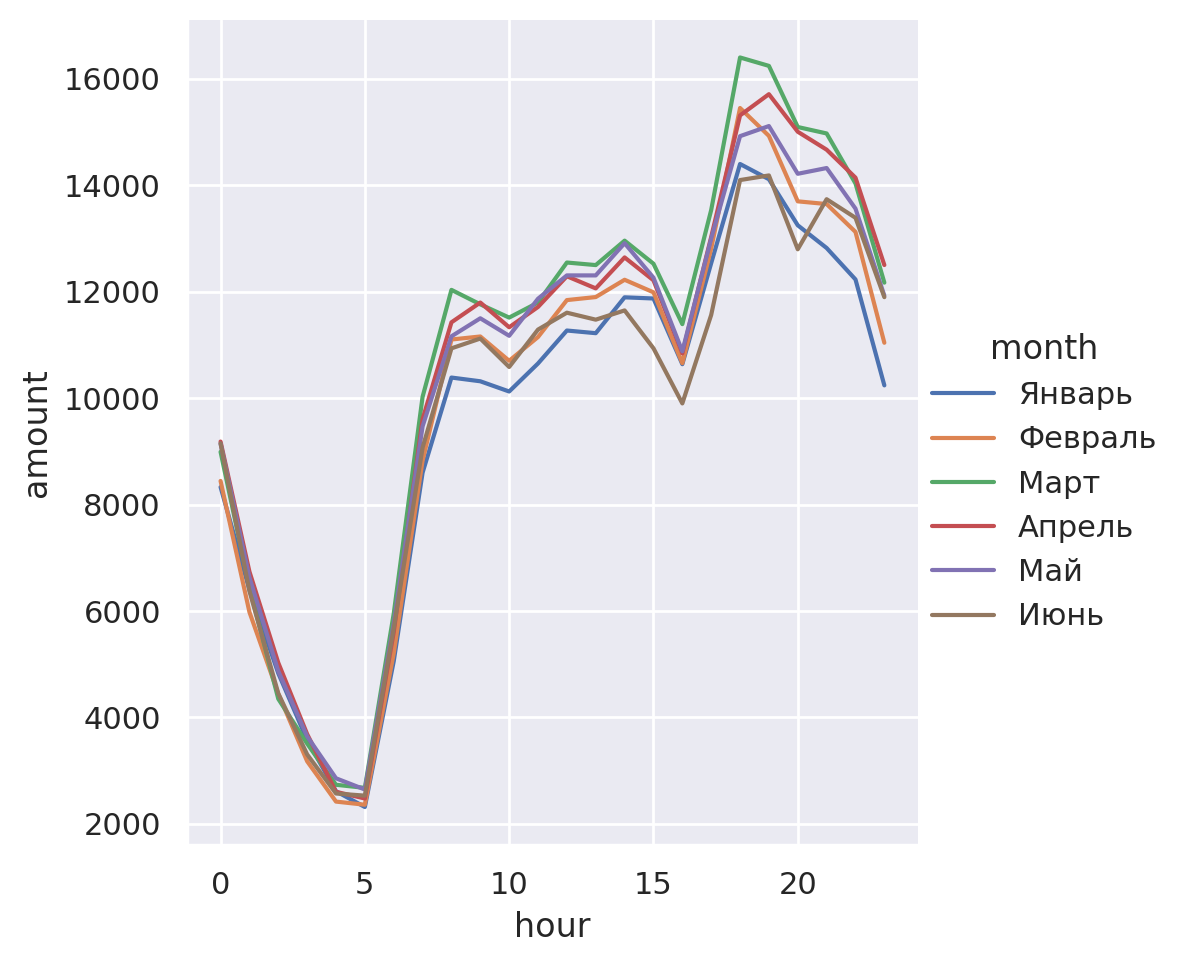

In [ ]:
g = sns.relplot(
    data=in_month,
    x="hour",
    y="amount",
    hue="month",
    kind="line"
)

In [22]:
day_names = {
    0: 'Понедельник',
    1: 'Вторник',
    2: 'Среда',
    3: 'Четверг',
    4: 'Пятница',
    5: 'Суббота',
    6: 'Воскресенье'
}

in_weekday['weekday'] = in_weekday['weekday'].map(day_names)


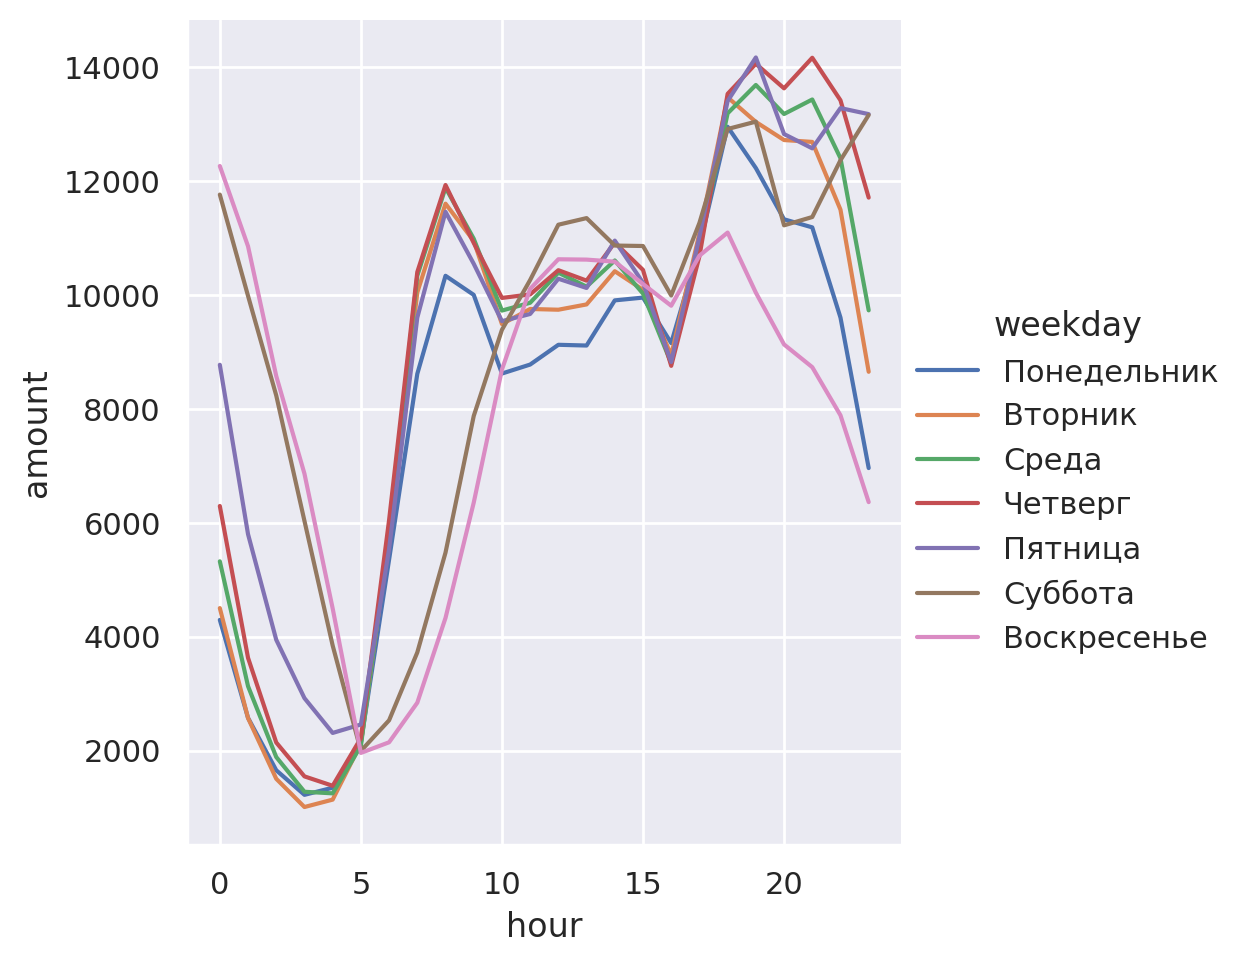

In [ ]:
g = sns.relplot(
    data=in_weekday,
    x="hour",
    y="amount",
    hue="weekday",
    kind="line"
)

**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше? Выделяются ли какие-нибудь дни недели? Месяца? Время суток? С чем это может быть связано?

По месяцам можно сказать, что не меняется количество вызовов такси во времени суток, графики один повторяют другой, но можно выделить, что в январе меньше заказывают такси, чем в марте.


Совершенно другая картина для графиков по дням недели, там сильно выбиваются выходные, люди встают позже, а в пятницу и в субботу поздно возвращаются. В воскресенье перед работой возвращаются домой пораньше.

**Задание 4 [+0.25 балла]**. Разделите данные на обучающую и тестовую выборки в соотношении 80:20 с помощью функции `train_test_split` из библиотеки `sklearn`. На основе обучающей выборки постройте график, показывающий зависимость логарифма среднего времени поездки от дня недели. Повторите этот процесс для часа в сутках и дня в году.

Посмотреть график распределения тренировочной выборки важно по нескольким причинам:

1. **Понимание данных**: Анализ тренировочной выборки помогает лучше понять распределение и характеристики данных, что важно для выбора и настройки моделей машинного обучения

2. **Выявление закономерностей**: Графики зависимостей могут выявить важные закономерности и тренды в данных, которые могут быть использованы для улучшения моделей прогнозирования.

3. **Избежание переобучения**: Анализируя только тренировочную выборку, мы избегаем риска "заглядывания в будущее" и переобучения модели, когда она слишком хорошо подгоняется под тестовые данные.


In [23]:
X = df_train.drop(columns=['trip_duration'])
y = df_train['trip_duration']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
for x in df_train.columns:
    print(x)

id
vendor_id
pickup_datetime
passenger_count
pickup_longitude
pickup_latitude
dropoff_longitude
dropoff_latitude
store_and_fwd_flag
trip_duration
day_of_year
weekday
hour
month
log_trip_duration


Добавьте следующие признаки на основе `pickup_datetime` (не зря мы преобразовывали это в первых этапах):
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

Разбиение даты на отдельные признаки важно по нескольким причинам:

1. **Выявление временных закономерностей**: Разделение даты на день недели, месяц и час помогает выявить закономерности в данных, связанные с временем суток, днями недели и сезонностью.

2. **Улучшение прогностической способности модели**: Добавление этих признаков может улучшить точность моделей машинного обучения, поскольку они могут захватывать важные временные зависимости в данных.

3. **Адаптация к аномальным событиям**: Бинарные признаки, указывающие на аномальные периоды, позволяют модели учитывать особые ситуации, которые могут существенно отличаться от обычных условий.

4. **Повышение интерпретируемости**: Разбиение даты на отдельные компоненты делает модель более интерпретируемой, позволяя легче понять, как различные временные факторы влияют на целевую переменную.

In [ ]:
for x in df_train.columns:
    print(x)

id
vendor_id
pickup_datetime
passenger_count
pickup_longitude
pickup_latitude
dropoff_longitude
dropoff_latitude
store_and_fwd_flag
trip_duration
day_of_week
month
hour
day_of_year


In [25]:
anomalous_days = [22, 23, 151]

df_train['anomalous_day'] = df_train['day_of_year'].isin(anomalous_days)

In [26]:
df_train.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,day_of_year,weekday,hour,month,log_trip_duration,anomalous_day
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,455,74,0,17,3,6.120297,False
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,663,164,6,0,6,6.496775,False
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,19,1,11,1,7.661056,False
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,429,97,2,19,4,6.061457,False
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,435,86,5,13,3,6.075346,False


Итак, мы уже создали некоторое количество признаков.

**Вопрос**: Какие из признаков _стоит рассматривать в этой задаче_   как категориальные, а какие - как численные? Почему?

cat - категориальный, num - численный

id  - drop\
vendor_id - drop\
pickup_datetime - both cat and num (drop)\
passenger_count - num\
pickup_longitude - num \
pickup_latitude - num \
dropoff_longitude - num \
dropoff_latitude - num \
store_and_fwd_flag - cat \
day_of_week - cat \
month - cat \
hour - cat \
day_of_year - cat

**Задание 5 [+0.375 балла]**.
Обучите регрессию `Ridge` с использованием параметров по умолчанию, применив `OneHotEncoder` для кодирования всех категориальных признаков и `StandardScaler` для масштабирования численных признаков (используйте `ColumnTransformer` и `PipeLine`. Ограничьтесь признаками, которые мы определили в этой части задания. Замерьте качество на тестовой выборке (RMSLE)

Применение `OneHotEncoder` и `StandardScaler` важно по следующим причинам:

1. **OneHotEncoder для категориальных признаков**: Категориальные признаки необходимо преобразовать в числовой формат перед использованием в линейной регрессии. `OneHotEncoder` преобразует категориальные переменные в бинарные векторы, что позволяет модели корректно интерпретировать эти признаки без внесения искажений, связанных с порядком значений.

2. **StandardScaler для численных признаков**: Масштабирование численных признаков с помощью `StandardScaler` помогает стандартизировать данные, приводя их к одному масштабу с нулевым средним и единичным стандартным отклонением. Это улучшает интерпретацию весов линейной модели (а также мы обсудим на лекции, почему это ускоряет обучение модели)


In [27]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 16 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   passenger_count     1458644 non-null  int64         
 4   pickup_longitude    1458644 non-null  float64       
 5   pickup_latitude     1458644 non-null  float64       
 6   dropoff_longitude   1458644 non-null  float64       
 7   dropoff_latitude    1458644 non-null  float64       
 8   store_and_fwd_flag  1458644 non-null  object        
 9   trip_duration       1458644 non-null  int64         
 10  day_of_year         1458644 non-null  int32         
 11  weekday             1458644 non-null  int32         
 12  hour                1458644 non-null  int32         
 13  month       

In [28]:
df_train.drop('id', axis=1, inplace=True)
df_train.drop('pickup_datetime', axis=1, inplace=True)

In [29]:
month_names = {
    1: 'Январь',
    2: 'Февраль',
    3: 'Март',
    4: 'Апрель',
    5: 'Май',
    6: 'Июнь'
}

df_train['month'] = df_train['month'].map(month_names)

In [30]:
day_names = {
    0: 'Понедельник',
    1: 'Вторник',
    2: 'Среда',
    3: 'Четверг',
    4: 'Пятница',
    5: 'Суббота',
    6: 'Воскресенье'
}

df_train['weekday'] = df_train['weekday'].map(day_names)


In [31]:
hour_names = {
    0: 'Полночь',
    1: 'Час ночи',
    2: '2 часа ночи',
    3: '3 часа ночи',
    4: '4 часа ночи',
    5: '5 часов утра',
    6: '6 часов утра',
    7: '7 часов утра',
    8: '8 часов утра',
    9: '9 часов утра',
    10: '10 часов утра',
    11: '11 часов утра',
    12: 'Полдень',
    13: 'Час дня',
    14: '2 часа дня',
    15: '3 часа дня',
    16: '4 часа дня',
    17: '5 часов вечера',
    18: '6 часов вечера',
    19: '7 часов вечера',
    20: '8 часов вечера',
    21: '9 часов вечера',
    22: '10 часов вечера',
    23: '11 часов вечера'
}

df_train['hour'] = df_train['hour'].map(hour_names)


In [32]:
df_train['log_trip_duration'] = df_train['trip_duration'].apply(np.log)

In [33]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 14 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   vendor_id           1458644 non-null  int64  
 1   passenger_count     1458644 non-null  int64  
 2   pickup_longitude    1458644 non-null  float64
 3   pickup_latitude     1458644 non-null  float64
 4   dropoff_longitude   1458644 non-null  float64
 5   dropoff_latitude    1458644 non-null  float64
 6   store_and_fwd_flag  1458644 non-null  object 
 7   trip_duration       1458644 non-null  int64  
 8   day_of_year         1458644 non-null  int32  
 9   weekday             1458644 non-null  object 
 10  hour                1458644 non-null  object 
 11  month               1458644 non-null  object 
 12  log_trip_duration   1458644 non-null  float64
 13  anomalous_day       1458644 non-null  bool   
dtypes: bool(1), float64(5), int32(1), int64(3), object(4)
memory usage

In [34]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [35]:
X = df_train.drop(columns=['log_trip_duration'])
y = df_train['log_trip_duration']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

categorical_features = list(df_train.dtypes[df_train.dtypes == "object"].index)
numeric_features = ['passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'vendor_id', 'day_of_year']

# Создание преобразователя для категориальных и числовых признаков
column_transformer = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ('scaler', StandardScaler(), numeric_features),
    ])

# Определение модели и создание конвейера
model = Ridge()
pipeline = Pipeline(steps=[('ohe_and_scaling', column_transformer),
                           ('regression', model)])

# Обучение модели
pipeline.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = pipeline.predict(X_test)

y_e_pred = np.exp(y_pred)

print(f"Test RMSLE = {mean_squared_log_error(y_test, y_pred, squared=False):.4f}")

# Расчет RMSLE
# rmsle = mean_squared_log_error(y_test, y_pred) ** 0.5
# print("RMSLE:", rmsle)

Test RMSLE = 0.1115


**Смотрите! Получилось!**

## Часть 2. Изучаем координаты & Обучаем модель [+1.5 балла]




Теперь, когда мы подробно изучили временные аспекты данных о поездках, давайте переключим наше внимание на географические данные, а именно на координаты начала и конца поездок. Мы предоставили вам функцию, которая отображает на карте точки начала или конца поездок. Однако обратите внимание, что для эффективности этой функции мы используем только небольшой фрагмент данных, иначе обработка займет слишком много времени.

Анализ координат важен по нескольким причинам:

1. **Пространственный анализ**: Координаты позволяют проводить пространственный анализ, который может выявить географические закономерности в данных, такие как популярные места отправления и назначения, районы с высоким спросом и т. д.

2. **Улучшение точности прогнозов**: Включение географических признаков в модели прогнозирования может повысить их точность, поскольку координаты могут быть связаны с различными факторами, влияющими на длительность поездок и спрос на транспортные услуги.

In [ ]:
import folium

In [ ]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    Рисует карту с кругами, представляющими точки данных.

    Параметры
    ----------
    data : DataFrame
        DataFrame, содержащий колонки с широтой и долготой.
    latitude_column : str
        Название колонки в DataFrame, содержащей координаты широты.
    longitude_column : str
        Название колонки в DataFrame, содержащей координаты долготы.
    color : str
        Цвет кругов, которые будут нарисованы на карте.

    Возвращает
    -------
    folium.Map
        Объект карты Folium с нарисованными кругами в указанных координатах.

    Примеры
    --------
    >>> import pandas as pd
    >>> data = pd.DataFrame({
    ...     'latitude': [37.773972, 37.774159],
    ...     'longitude': [-122.431297, -122.431297]
    ... })
    >>> show_circles_on_map(data, 'latitude', 'longitude', 'blue')
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [ ]:
show_circles_on_map(df_train.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

In [ ]:
show_circles_on_map(df_train.sample(1000), "dropoff_latitude", "dropoff_longitude", "blue")

**Вопрос**: Какие пункты (или скопления точек, в количестве 2-3), по вашему мнению, выделяются на карте от основной массы и могут быть полезны для нашей задачи? Почему вы их выбрали? В чём особенность этих скоплений точек для нашей задачи?

Есть 2 скопления в двух аэропортах. из них можно попробовать сделать отдельный бинарный признак, так как из аэропорта поездки явно дольше будут

**Задание 6 [+0.375 балла]**. Как нам хорошо известно, время поездки $t$ связано с расстоянием $s$ и средней скоростью $v_{\text{ср}}$ соотношением $t = s / v_{\text{ср}}$. Из этого следует, что расстояние между начальной и конечной точками поездки является одним из ключевых факторов, влияющих на время поездки. Хотя мы не можем точно определить полный маршрут, который преодолеет такси, мы можем оценить это расстояние, рассчитав кратчайшее расстояние между точками начала и конца поездки. Для корректного вычисления расстояния между двумя точками на поверхности Земли можно использовать функцию `haversine`. Рассчитайте кратчайшее расстояние для каждого объекта в данных и сохраните его в колонку `haversine`.

Это важно по нескольким причинам:

1. **Улучшение точности модели**: Включение расстояния как признака в модель может значительно улучшить точность прогнозирования времени поездки, поскольку оно напрямую влияет на длительность поездки.

2. **Понимание взаимосвязей**: Анализ зависимости времени поездки от расстояния может помочь выявить взаимосвязи и закономерности в данных, что полезно для понимания динамики транспортных потоков.


In [ ]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

In [ ]:
df_train.loc[:, 'haversine'] = haversine_array(df_train['pickup_latitude'].values, df_train['pickup_longitude'].values, df_train['dropoff_latitude'].values, df_train['dropoff_longitude'].values)

Так как мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$. Запишите логарифм `haversine` в отдельную колонку `log_haversine`:

In [ ]:
df_train['log_haversine'] = np.log(df_train['haversine'])

/Users/riter/anaconda3/envs/s7_case/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Убедимся, что логарифм расстояния лучше коррелирует с нашим таргетом, чем просто расстояние:

In [ ]:
df_train['log_trip_duration'] = df_train['trip_duration'].apply(np.log)

In [ ]:
your_df = df_train
assert your_df['log_haversine'].corr(your_df['log_trip_duration']) > your_df['haversine'].corr(your_df['log_trip_duration'])

/Users/riter/anaconda3/envs/s7_case/lib/python3.11/site-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


AssertionError: 

**Задание 7 [+0.375 балла]**. Давайте проанализируем среднюю скорость движения такси. Для каждого объекта в обучающей выборке вычислите среднюю скорость, разделив значение в колонке `haversine` на значение в колонке `trip_duration`. Затем постройте гистограмму распределения полученных значений средней скорости.


In [ ]:
#╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуйте гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать рассмотрение объекты, где скорость больше некоторой квантили):

In [ ]:
#╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

Не забудьте удалить колонку со значением скорости из данных!

**Вопрос**: Почему значение скорости нельзя использовать во время обучения?

╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

<img src="https://www.dropbox.com/s/xson9nukz5hba7c/map.png?raw=1" align="right" width="20%" style="margin-left: 20px; margin-bottom: 20px">

**Задание 8 [+0.625 балла]**. Сейчас мы практически не используем прямые значения координат в анализе. Это связано с тем, что широта и долгота по отдельности не несут значимой информации, а их взаимосвязь с целевой переменной нелинейна. Чтобы эффективно интегрировать координаты в наш анализ, мы можем применить следующий подход: окружим область с наибольшим количеством поездок прямоугольником и разделим этот прямоугольник на ячейки. Каждой точке присвоим номер ячейки, в которой она находится, а точкам вне прямоугольника присвоим значение -1.

Создайте трансформер, который вначале делит указанную область на ячейки, а затем генерирует два признака: номер ячейки начала поездки и номер ячейки конца поездки. Выбор количества строк и столбцов оставьте на ваше усмотрение.

Важно, чтобы все вычисления были векторизованными, трансформер не изменял исходный набор данных, а все необходимые статистики вычислялись только по обучающей выборке в методе `fit`.

Этот подход важен по следующим причинам:

1. **Учет пространственной структуры**: Разбиение на ячейки позволяет учесть пространственную структуру данных, что может улучшить качество анализа и прогнозирования.

2. **Снижение размерности**: Преобразование координат в номера ячеек уменьшает размерность данных, что упрощает анализ и сокращает время вычислений.

3. **Улучшение интерпретируемости**: Номера ячеек могут быть более интерпретируемыми, чем сырые координаты, что облегчает понимание взаимосвязей в данных.

4. **Адаптация к нелинейным зависимостям**: Такой подход позволяет адаптироваться к нелинейным зависимостям между координатами и целевой переменной, что может повысить точность моделей.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class MapGridTransformer(BaseEstimator, TransformerMixin):
    """
    Трансформер для преобразования географических координат в номера ячеек сетки.

    Параметры
    ----------
    n_rows : int
        Количество строк сетки.
    n_cols : int
        Количество столбцов сетки.
    lat_min : float
        Минимальная широта области.
    lat_max : float
        Максимальная широта области.
    lon_min : float
        Минимальная долгота области.
    lon_max : float
        Максимальная долгота области.

    Атрибуты
    ----------
    cell_size_lat : float
        Размер ячейки сетки по широте.
    cell_size_lon : float
        Размер ячейки сетки по долготе.

    Методы
    -------
    fit(X, y=None)
        Находит параметры сетки на основе данных.
    transform(X)
        Преобразует координаты в номера ячеек сетки.
    show_map()
        Отображает карту с ячейками сетки.
    """

    def __init__(self, n_rows, n_cols, lat_min, lat_max, lon_min, lon_max):
        #╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

    def fit(self, X=None, y=None):
        """
        Находит параметры сетки на основе данных.

        Параметры
        ----------
        X : array-like, shape [n_samples, 2]
            Входные данные с координатами (широта, долгота).
        y : Ignored
            Не используется, существует для совместимости со стандартами sklearn.

        Возвращает
        -------
        self : object
            Возвращает себя.
        """
        #╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ
        return self

    def transform(self, X):
        """
        Преобразует координаты в номера ячеек сетки.

        Параметры
        ----------
        X : array-like, shape [n_samples, 2]
            Входные данные с координатами (широта, долгота).

        Возвращает
        -------
        X_transformed : array, shape [n_samples, 2]
            Преобразованные данные с номерами ячеек (номер строки, номер столбца).
        """
        #╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ
        return X_transformed

    def show_map(self):
        """
        Отображает карту с ячейками сетки.
        """
        #╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ
        pass


**Задание 9 [+0.125 балла]**. Обучите регрессию `Ridge` с использованием параметров по умолчанию, применив `OneHotEncoder` для кодирования всех категориальных признаков и `StandardScaler` для масштабирования численных признаков (используйте `ColumnTransformer` и `PipeLine`. Ограничьтесь признаками, которые мы определили до этой части задания. Замерьте качество на тестовой выборке (RMSLE)

In [ ]:
#╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

## Часть 3. Изучаем оставшиеся признаки & Обучаем модель [+0.5 балла]


**Задание 10 [+0.375 балла]**. У нас осталось еще 3 признака, которые мы не исследовали: `vendor_id`, `passenger_count` и `store_and_fwd_flag`.

**Вопрос**: Подумайте, почему каждый из этих признаков может быть потенциально полезным.

Посчитайте, сколько есть уникальных значений у каждого из этих признаков:

In [ ]:
print(df_train.vendor_id.nunique())
print(df_train.passenger_count.nunique())
print(df_train.store_and_fwd_flag.nunique())

2
10
2


Постройте "ящики с усами" распределений логарифма времени поездки в зависимости от значений каждого из признаков

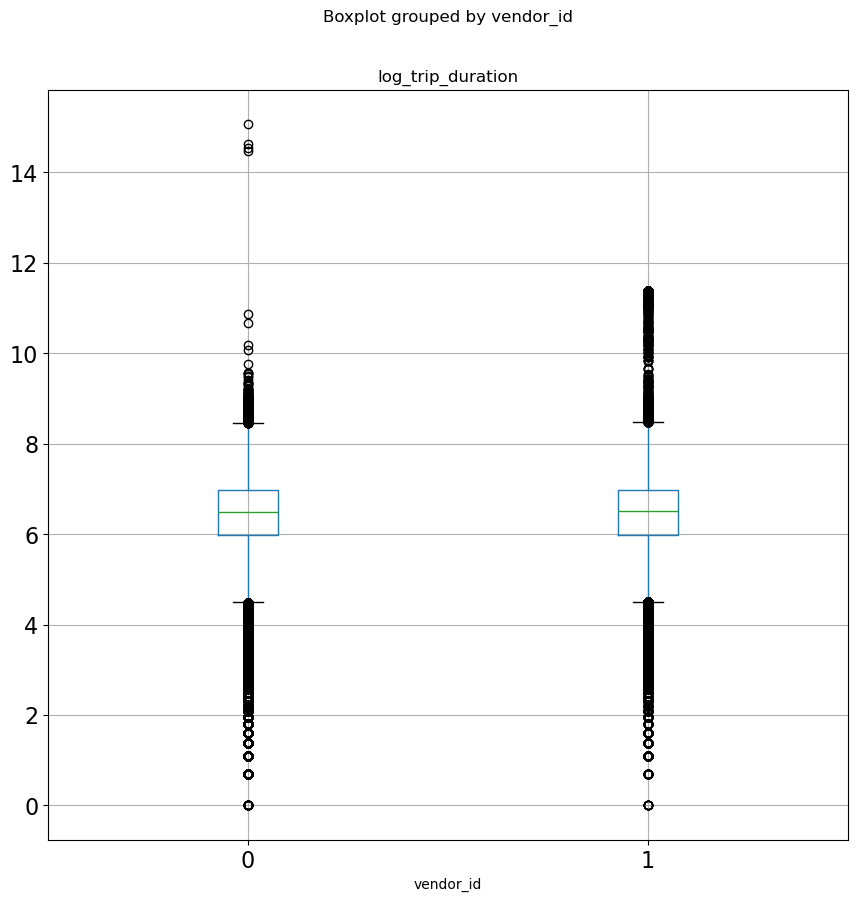

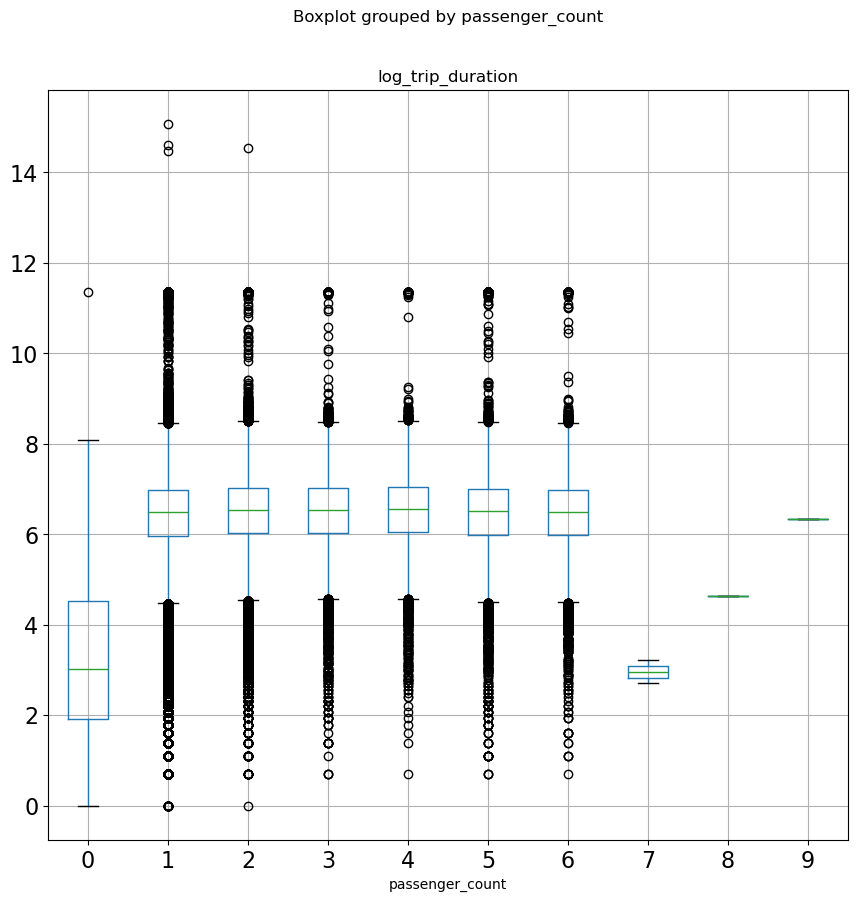

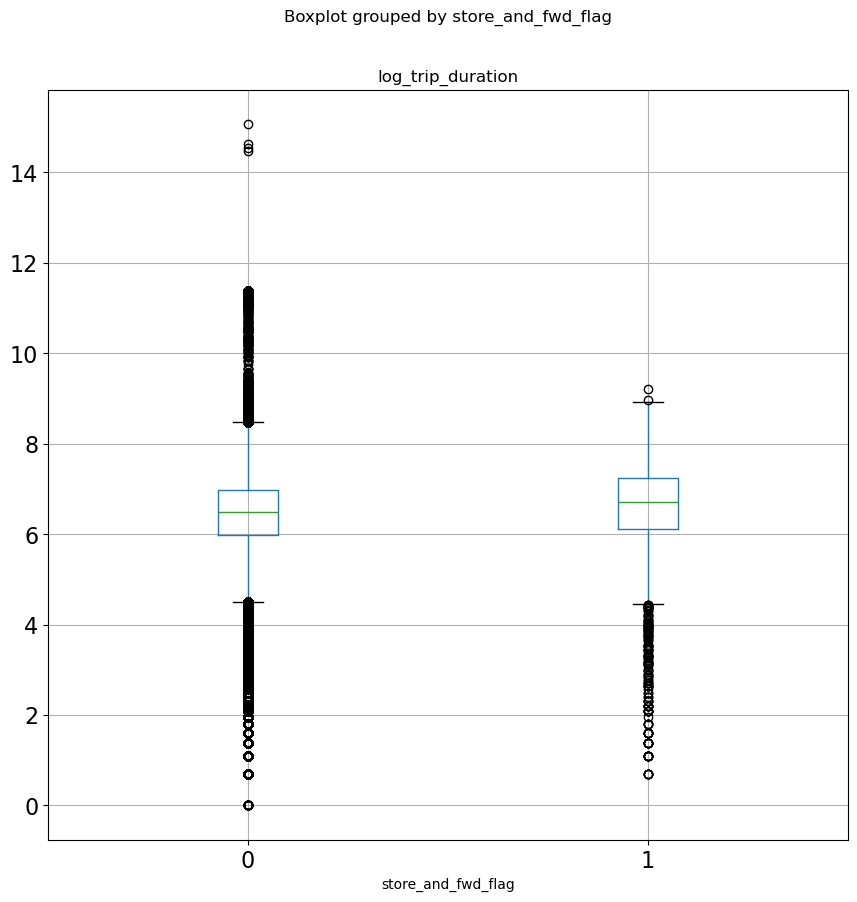

In [ ]:
df_train.boxplot(
    column=["log_trip_duration"], by="vendor_id", fontsize=16, figsize=(10, 10)
);

df_train.boxplot(
    column=["log_trip_duration"], by="passenger_count", fontsize=16, figsize=(10, 10)
);

df_train.boxplot(
    column=["log_trip_duration"], by="store_and_fwd_flag", fontsize=16, figsize=(10, 10)
);


Переведите признаки `vendor_id` и `store_and_fwd_flag` в значения $\{0;1\}$

In [ ]:
df_train['vendor_id'] = df_train['vendor_id'].replace({1: 0, 2: 1})

df_train['store_and_fwd_flag'] = df_train['store_and_fwd_flag'].replace({'N': 0, 'Y': 1})

**Вопрос**: Основываясь на графиках выше, как вы думаете, будут ли эти признаки сильными?

store_and_fwd_flag при значении 1 в основном большие дюрации, vendor_id поможет отличить несколько выбросов

**Задание 11 [+0.125 балла]**. Обучите регрессию `Ridge` с использованием параметров по умолчанию, применив `OneHotEncoder` для кодирования всех категориальных признаков и `StandardScaler` для масштабирования численных признаков (используйте `ColumnTransformer` и `PipeLine`. Ограничьтесь признаками, которые мы определили в этой части задания. Замерьте качество на тестовой выборке (RMSLE)

In [ ]:
#╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

Если признаки не дали какого-то ощутимого улучшения метрики, их можно выбросить из данных.

## Часть 4. Улучшаем модель [+1.5 балла]

**Задание 12 [+0.5 балла]**. В нашем наборе данных присутствуют аномальные записи: объекты с необычно коротким временем поездки, слишком большим пройденным расстоянием или с большими остатками после регрессии. В этом задании предлагается исключить такие объекты из обучающего набора. Для этого постройте гистограммы распределения указанных величин, определите объекты, которые можно считать выбросами, и очистите __обучающий набор__ от них.

Следует отметить, что, несмотря на то что эти объекты кажутся выбросами, в тестовом наборе данных также могут присутствовать объекты с аналогичными аномальными значениями. Поэтому удаление выбросов из обучающего набора может привести к ухудшению качества на тестовом наборе. Однако, в целом, рекомендуется удалять выбросы из обучающего набора, чтобы получить более разумную и интерпретируемую модель.

Для определения выбросов можно использовать различные методы, такие как:

- **Z-оценка**: Выбросы определяются как объекты, у которых абсолютное значение Z-оценки (стандартизированное значение) превышает определенный порог (например, 3).

- **IQR (межквартильный размах)**: Выбросы определяются как объекты, значения которых выходят за пределы [Q1 - 1.5 * IQR, Q3 + 1.5 * IQR], где Q1 и Q3 — первый и третий квартили соответственно.


In [ ]:
#╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

Сейчас у нас очень много категориальных признаков. В категориальных признаках могут содержаться редкие категории, обычно это плохо: модель сильно переобучается на таких примерах. Для каждого категориального признака объедините действительно редкие категории в одну, если такие имеются (т.е. если категории действительно редкие).

In [ ]:
#╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

Обучите регрессию `Ridge` с использованием параметров по умолчанию, применив `OneHotEncoder` для кодирования всех категориальных признаков и `StandardScaler` для масштабирования численных признаков (используйте `ColumnTransformer` и `PipeLine`. Ограничьтесь признаками, которые мы сделали до этой части задания. Замерьте качество на тестовой выборке (RMSLE)

In [ ]:
#╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

**Задание 13 [+0.5 балла]**. После OneHot-кодирования количество признаков в нашем датасете сильно возрастает. Посчитайте колиество признаков до и после кодирования категориальных признаков.

In [ ]:
#╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

Попробуйте обучить не `Ridge`-, а `Lasso`-регрессию. Какой метод лучше?

In [ ]:
#╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

По тренировочной выборке с помощью кросс-валидации (`zGridSearchCV`) подберите оптимальные значения параметра регуляризации (alpha, lambda в разных литературах по-разному) для `Ridge` и `Lasso` на тестовой выборке измерьте качество лучшей полученной модели.

In [ ]:
#╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

<img src="https://www.dropbox.com/s/wp4jj0599np17lh/map_direction.png?raw=1" width="20%" align="right" style="margin-left: 20px">

**Задание 14 [+0.5 балла]**. Использование взаимодействия признаков часто оказывается полезным для улучшения качества модели. Мы уже разделили карту Манхэттена на ячейки и создали признаки, указывающие на ячейку начала и окончания поездки.

Теперь предлагается пойти дальше и посчитать, как часто встречается каждая возможная пара этих признаков в нашем наборе данных. Затем выберем 100 самых частых пар и закодируем поездки с этими парами как категориальный признак, а для остальных объектов установим значение -1. Таким образом, мы сможем кодировать информацию о маршруте поездки такси.

Создание таких признаков может быть круто по нескольким причинам:

1. **Улучшение предсказаний**: Комбинация начальной и конечной точек поездки может содержать важную информацию о времени поездки, которая поможет улучшить предсказательную способность модели.

2. **Выявление популярных маршрутов**: Анализ самых частых пар ячеек может помочь выявить наиболее популярные маршруты, что может быть полезно для планирования транспортных услуг.

3. **Интерпретируемость**: Новые признаки, основанные на маршрутах, могут улучшить интерпретируемость модели, позволяя лучше понять, как различные маршруты влияют на время поездки.

4. **Адаптация к специфике данных**: Такой подход позволяет адаптировать модель к специфике данных о поездках такси, учитывая географическую структуру города и особенности движения.

Также вы можете придумать другие способы создания признаков, связанных с маршрутом, которые могут дать дополнительные баллы при сдаче этого домашнего задания


In [ ]:
#╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

**Вопрос**: Почему такой признак потенциально полезный? Почему линейная модель не может самостоятельно "вытащить" эту информацию, ведь у нее в распоряжении есть признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка"?

╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

Заново обучите модель (`Ridge`, если она дала более высокое качество в предыдущих экспериментах, и `Lasso` иначе) на новых даннных и посчитайте качество на тестовой выборке

In [ ]:
#╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

## Часть 5. САМОЕ ВАЖНОЕ [+5 баллов]

Время соревнований. Кто сделает лучшую метрику RMSLE - тот победил. Разрешено использовать любые модели

RMSLE < 0.28 - 5 баллов

0.315 > RMSLE >= 0.28 - 4 балла

0.34 > RMSLE >= 0.315 - 3 балла

0.36 > RMSLE >= 0.34 - 2 балла

RMSLE > 0.36 - 0 баллов

Посмотрите метрики перед 2 частью, у нас там мало))))))))) Test RMSLE = 0.1115

In [ ]:
train = pd.read_csv('nyc-taxi-trip-duration/train.csv')
test = pd.read_csv('nyc-taxi-trip-duration/test.csv')

In [ ]:
train['pickup_datetime']

0          2016-03-14 17:24:55
1          2016-06-12 00:43:35
2          2016-01-19 11:35:24
3          2016-04-06 19:32:31
4          2016-03-26 13:30:55
                  ...         
1458639    2016-04-08 13:31:04
1458640    2016-01-10 07:35:15
1458641    2016-04-22 06:57:41
1458642    2016-01-05 15:56:26
1458643    2016-04-05 14:44:25
Name: pickup_datetime, Length: 1458644, dtype: object

In [ ]:
train = train.sort_values(by='pickup_datetime').reset_index(drop=True)